# Convex Optimization – Homework 1
Made by Kristian Kuznetsov

In [ ]:
#!pip install cvxpy

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

## Task 2

First let's download image and define some helping functions

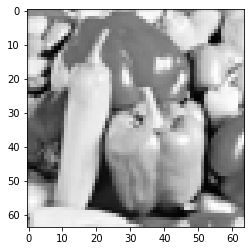

In [3]:
from PIL import Image

# get image of the needed size from the path
def get_image(n, path = 'image.jpg'):
    img = Image.open(path)
    size = n, n
    img.thumbnail(size)
    Y = np.array(img.convert('L'))
    return Y

# plot one image from the np.array
def plot_image(Y):
    plt.imshow(Image.fromarray(Y), cmap='Greys_r')
    
n = 64
Y = get_image(n)
plot_image(Y)

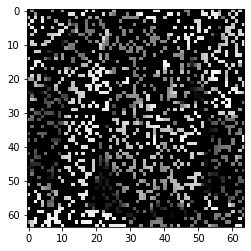

In [4]:
# generate mask W and Yw used for reconstruction
def generate_missing(Y, missing_ratio):
    n = Y.shape[0]
    W = np.random.rand(n,n) > missing_ratio
    Yw = W * Y
    return Yw, W

missing_ratio = 0.70
delta = 0.005
Yw, W = generate_missing(Y, missing_ratio)
plot_image(Yw)

### Slow algorithm
We will implement the direct algorithm for the following minimization problem:

$$\min _{\mathbf{X}}\|\mathbf{X}\|_{*} \quad \text { s.t. } \quad\|\mathbf{W} \circledast(\mathbf{Y}-\mathbf{X})\|_{F}^{2} \leq \delta^{2}$$

In [5]:
from cvxpy import multiply

# a function that provides reconstructed image
def complete_image_slow(Y, W, delta = 0.005):
    X = cp.Variable(Y.shape)
    obj = cp.Minimize(cp.norm(X, 'nuc'))
    X_masked = multiply(W, X)
    Y_masked = multiply(W, Y)
    constr = [cp.sum_squares(X_masked - Y_masked) <= delta**2]
    prob = cp.Problem(obj, constr)
    prob.solve()
    return X.value, prob.value

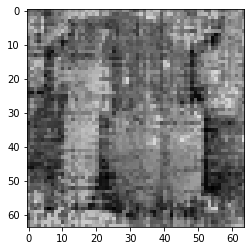

In [6]:
X, value = complete_image_slow(Y, W, delta = 0.005)
plot_image(W*Y + ~W*X)

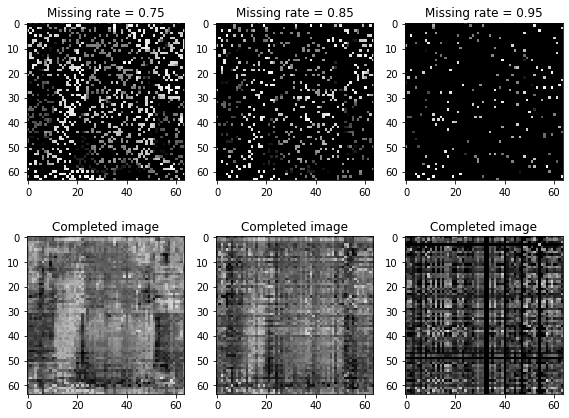

In [7]:
fig, axs = plt.subplots(2, 3, figsize = (9.6, 7.2))
rates = [0.75, 0.85, 0.95]
for i, mr in enumerate(rates):
    Yw, W = generate_missing(Y, mr)
    axs[0, i].imshow(Image.fromarray(Yw), cmap='Greys_r')
    axs[0, i].set_title('Missing rate = {mr}'.format(mr=mr))
    X, value = complete_image_slow(Y, W, delta = 0.005)
    axs[1, i].imshow(Image.fromarray(W*Y + ~W*X), cmap='Greys_r')
    axs[1, i].set_title('Completed image')

/opt/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1295: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


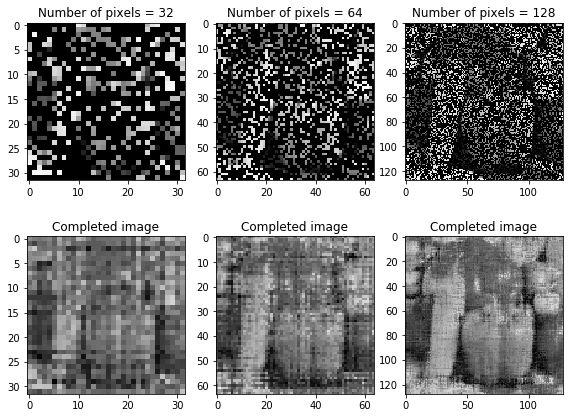

In [8]:
fig, axs = plt.subplots(2, 3, figsize = (9.6, 7.2))
sizes = [32, 64, 128]
for i, n in enumerate(sizes):
    Y = get_image(n)
    Yw, W = generate_missing(Y, 0.70)
    axs[0, i].imshow(Image.fromarray(Yw), cmap='Greys_r')
    axs[0, i].set_title('Number of pixels = {n}'.format(n=n))
    X, value = complete_image_slow(Y, W, delta = 0.005)
    axs[1, i].imshow(Image.fromarray(W*Y + ~W*X), cmap='Greys_r')
    axs[1, i].set_title('Completed image')

We can see above two sets of pictures. The first six pictures represent completion of 64x64 image with missing rates 0.75, 0.85 and 0.95. With missing rate 0.75 we can see some outlines of figures, but with other missing rates it is impossible to see something. 

The second set of six pictures represents completion of 32x23, 64x64 and 128x128 images with missing rate 0.70. We can see that the more pixels we take for the image size, the better is image completion. However, for big images this algorithm is working very slow and crashes.

### Fast algorithm

We divide initial problem into different parts by introducing new variable $\mathbf{Z}$:
$$
\begin{array}{ll}
\min _{\mathbf{X}, \mathbf{Z}} & \|\mathbf{X}\|_{*}+i_{\mathcal{D}}(\mathbf{Z}) \\
\text { s.t. } & \mathbf{X}=\mathbf{Z}
\end{array}
$$
where $\mathcal{D}=\left\{\mathbf{Z} \mid\|\mathbf{W} \circledast(\mathbf{Y}-\mathbf{Z})\|_{F}^{2} \leq \delta^{2}\right\}$ and $i_{\mathcal{D}}(\mathbf{Z})$ is an indicator if $\mathbf{Z} \in \mathcal{D}$. Then we can solve it by steps:

$$
\begin{array}{l}
\mathbf{X}=\underset{\mathbf{X}}{\arg \min } \mathcal{L}(\mathbf{X}, \mathbf{Z}, \mathbf{T})=\underset{\mathbf{X}}{\arg \min }\|\mathbf{X}\|_{*}+\frac{\lambda}{2}\|\mathbf{X}-\mathbf{Z}-\mathbf{T}\|_{F}^{2} \\
\mathbf{Z}=\underset{\mathbf{Z}}{\arg \min } \mathcal{L}(\mathbf{X}, \mathbf{Z}, \mathbf{T})=\underset{\mathbf{Z}}{\arg \min } i_{\mathcal{D}}(\mathbf{Z})+\frac{\lambda}{2}\|\mathbf{X}-\mathbf{Z}-\mathbf{T}\|_{F}^{2} \\
\mathbf{T} \leftarrow \mathbf{T}+\mathbf{Z}-\mathbf{X}
\end{array}
$$

Here we find $\mathbf{X}^*$ as truncated SVD: $\mathbf{X}^* = \mathbf{U} \operatorname{diag}\left(\max \left(\sigma-\frac{1}{\lambda}, 0\right)\right) \mathbf{V}^{T}$. And $\mathbf{Z}$ is updated as follows: $\mathbf{Z} = \mathbf{X} - \mathbf{T} + (1 - \frac{\delta}{\|\mathbf{H}\|_{F}}) \mathbf{H}$

In [9]:
from scipy.ndimage import gaussian_filter

def min_normnuc(Y, delta, W, X, T, smoothfilter, max_iters = 500, verbose = False):
    err = []
    fval = []
    l = 0.05
    for ki in range(max_iters):
        H = W * (Y - X + T)
        alpha = np.sqrt(delta)/np.linalg.norm(H, ord='fro')
        D3 = H*(1-alpha)
        Z = X-T+D3
        
        u,s,v = np.linalg.svd(Z+T)
        s = np.diag(s)
        s = np.maximum((s - 1/l), np.zeros(s.shape))
        s[s<1e-6] = 0
        rankX = np.count_nonzero(s)
        u = u[:, :rankX]
        v = v[:rankX, :]
        s = s[:rankX, :rankX]
        X = u @ s @ v
        if smoothfilter != 0:
            X = gaussian_filter(X, smoothfilter)
            
        T = T + Z - X
        err.append(np.linalg.norm(Z-X, ord='fro'))
        fval.append(np.linalg.norm(X, ord='nuc'))
        if ki > 1 and verbose:
            print('{ki} fk-f(k-1) = {err_prev}, ||X - Z||F = {err}'.format(ki = ki, err_prev = 
                                                                           abs(fval[ki]-fval[ki-1]),
                                                                           err = err[ki]))
        if (ki > 1) and abs(fval[ki]-fval[ki-1])<1e-4:
            break
    return X, fval

In [10]:
n = 128
Y = get_image(n)
missing_ratio = 0.70
Yw, W = generate_missing(Y, missing_ratio)

T = np.zeros(Y.shape)
X = np.zeros(Y.shape)
delta = 1
smoothfilter = 2
X, fval = min_normnuc(Yw, delta, W, X, T, smoothfilter)

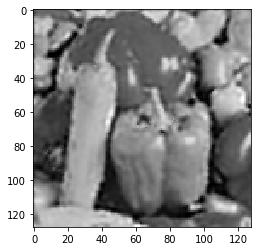

In [11]:
plot_image(W*Y + ~W*X)

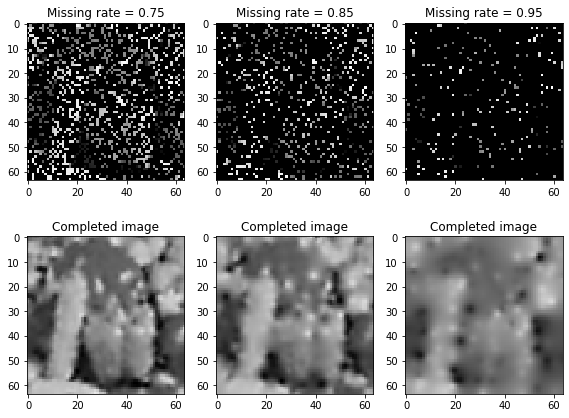

In [12]:
fig, axs = plt.subplots(2, 3, figsize = (9.6, 7.2))
rates = [0.75, 0.85, 0.95]
for i, mr in enumerate(rates):
    Y = get_image(64)
    Yw, W = generate_missing(Y, mr)
    axs[0, i].imshow(Image.fromarray(Yw), cmap='Greys_r')
    axs[0, i].set_title('Missing rate = {mr}'.format(mr=mr))
    T = np.zeros(Y.shape)
    X = np.zeros(Y.shape)
    delta = 1
    smoothfilter = 1
    X, fval = min_normnuc(Yw, delta, W, X, T, smoothfilter)
    axs[1, i].imshow(Image.fromarray(W*Y + ~W*X), cmap='Greys_r')
    axs[1, i].set_title('Completed image')

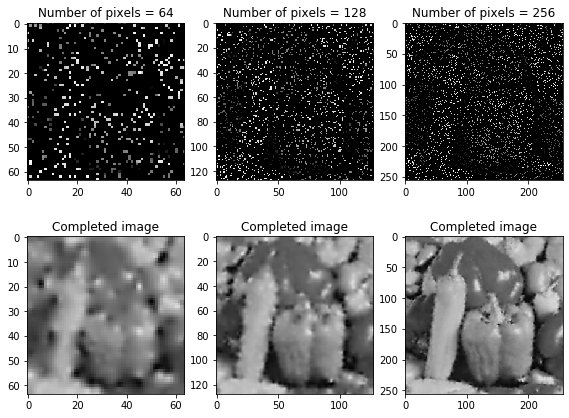

In [13]:
fig, axs = plt.subplots(2, 3, figsize = (9.6, 7.2))
sizes = [64, 128, 256]
for i, n in enumerate(sizes):
    Y = get_image(n)
    Yw, W = generate_missing(Y, 0.90)
    axs[0, i].imshow(Image.fromarray(Yw), cmap='Greys_r')
    axs[0, i].set_title('Number of pixels = {n}'.format(n=n))
    T = np.zeros(Y.shape)
    X = np.zeros(Y.shape)
    delta = 1
    smoothfilter = 1
    X, fval = min_normnuc(Yw, delta, W, X, T, smoothfilter)
    axs[1, i].imshow(Image.fromarray(W*Y + ~W*X), cmap='Greys_r')
    axs[1, i].set_title('Completed image')

We can see that this algorithm is working much more efficiently and precisely than the first one. And also it is much faster. Now we will try to inspect the behavior of the algorithm for critical positions of pixels. We will construct artificial $W$: generate missing values with normal distribution with different centers

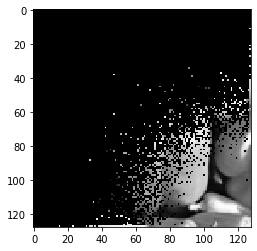

In [14]:
def constructW_normal(Y, missing_ratio, loc, scale):
    n = Y.shape[0]
    W = np.zeros((n, n)).astype(np.uint8)
    count_rate = int(n**2 * (1 - missing_ratio))
    i = 0
    while i < count_rate:
        c1 = int(np.random.normal(loc[0], scale))
        c2 = int(np.random.normal(loc[1], scale))
        c1, c2 = min(c1, n-1), min(c2, n-1)
        c1, c2 = max(c1, 0), max(c2, 0)
        if W[c1, c2] == 0:
            W[c1, c2] = 1
            i+=1
    Yw = W*Y
    return Yw, W
n = 128
Y = get_image(n)
Yw, W = constructW_normal(Y, 0.8, loc=[n, n], scale = n//5)
plot_image(Yw)

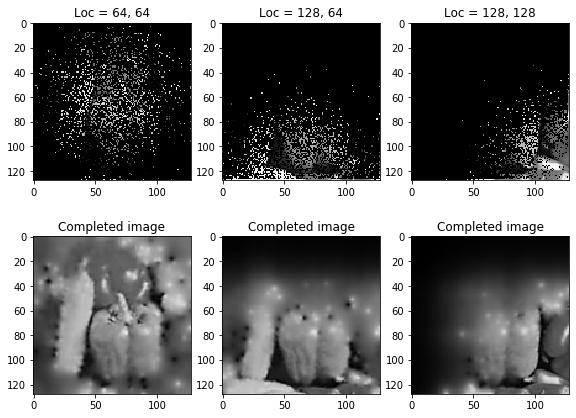

In [15]:
fig, axs = plt.subplots(2, 3, figsize = (9.6, 7.2))
n=128
locs = [(n//2, n//2), (n, n//2), (n, n)]
scale = n//5
for i, loc in enumerate(locs):
    Y = get_image(n)
    Yw, W = constructW_normal(Y, 0.9, loc=loc, scale = scale)
    axs[0, i].imshow(Image.fromarray(Yw), cmap='Greys_r')
    axs[0, i].set_title('Loc = {l1}, {l2}'.format(l1=loc[0], l2 = loc[1]))
    T = np.zeros(Y.shape)
    X = np.zeros(Y.shape)
    delta = 1
    smoothfilter = 1
    X, fval = min_normnuc(Yw, delta, W, X, T, smoothfilter)
    axs[1, i].imshow(Image.fromarray(X), cmap='Greys_r')
    axs[1, i].set_title('Completed image')

It seems to be that the more uniform the distribution of known pixels is, the better is the image completion. We can observe that if we use normal distribution, the center of distribution is reconstructed very precisely, but other areas are blured. 

## Task 3
**(a)** First recall the definition of polyhedra: $$S = \{x | Ax \preceq b, Cx = d \}$$
Let's consider ell-1 norm ball $C$. For the case of $x\in \mathbb{R}^2$ we can rewrite $\|x\|_1 \leq 2$ as $|x_1| + |x_2| \leq 2$. We can get rid of the absolute values and obtain the following system:
$$x_1 + x_2 \leq 2$$
$$x_1 - x_2 \leq 2$$
$$-x_1 + x_2 \leq 2$$
$$-x_1 - x_2 \leq 2$$
And it can be written as $A_c x \preceq b_c$, where
$$
A_c = \begin{bmatrix}
1 & 1 \\
1 & -1 \\
-1 & 1 \\
-1 & 1 \\
\end{bmatrix} \qquad
b_c = \begin{bmatrix}
2 \\
2 \\
2 \\
2\\
\end{bmatrix}
$$

Therefore, $C = \{x \in \mathbb{R}^2 | A_c x \preceq b_c\}$ and is a polyhedra ($A = A_c$, $b = b_c$ $C = 0$, $d = 0$ in the definition of polyhedra)

Then let's consider $D$. We can write $\|x-c\|_{\infty} \leq 1$ as $\max_i |x - [4, 3]^T| \leq 1$ or $\max\{ |x_1 - 4|, |x_2 - 3| \} \leq 1$. The system of inequalities for this problem is following:
$$x_2 \leq 4$$
$$-x_2 \leq -2$$
$$x_1 \leq 5$$
$$-x_1 \leq -3$$
Hence, $D$ is a polyhedra because $D = \{x \in \mathbb{R}^2 | A_d x \preceq b_d\}$ for 
$$
A_d = \begin{bmatrix}
0 & 1 \\
0 & -1 \\
1 & 0 \\
-1 & 0 \\
\end{bmatrix} \qquad
b_d = \begin{bmatrix}
4 \\
-2 \\
5 \\
-3\\
\end{bmatrix}
$$

**(b)** The optimization problem is the following:
$$\begin{aligned}
\min \|x - y\|_2 & \\
A_c x \preceq b_c & \\
A_d y \preceq b_d & \\
\end{aligned}$$

**(c)** The objective function of quadratic programming problem is the function $\dfrac{1}{2} x^T Q x + c^T x$. We will replace $\|x - y\|_2$ in the initial problem by $\dfrac{1}{2} \|x - y\|_2^2$. Then, to reformulate this problem we should introduce some matrices and new variable. Let 
$$z = \begin{bmatrix} x \\ y \\ \end{bmatrix}$$
Then to obtain $x-y$ we introduce $2\times 4$ block matrix 
$$P = \begin{bmatrix} I_2 & -I_2 \end{bmatrix}, \qquad x-y = Pz$$
We can see that $\dfrac{1}{2} \|x - y\|_2^2 = \dfrac{1}{2} \|Pz\|_2^2 = \dfrac{1}{2} (Pz)^T (Pz) = \dfrac{1}{2} z^T (P^T P)z$. We will denote $Q = P^T P$. So we have obtained quadratic programming objective function $\dfrac{1}{2} z^T Qz$.

Then we should reformulate the inequality constraints. Let's introduce $8\times 4$ block matrix and a vector:
$$
\hat{A} = \begin{bmatrix} A_c & 0 \\ 0 & A_d \end{bmatrix}, \qquad
\hat{b} = \begin{bmatrix} b_c \\ b_d \end{bmatrix}$$
Then inequality constraints will be the following: $\hat{A} \preceq \hat{b} $. And the minimization problem is:
$$\begin{aligned}
\min \dfrac{1}{2} z^T Qz & \\
\hat{A} \preceq \hat{b} & \\
\end{aligned}$$

**(d)** Then we can solve it using CVXPY:

In [16]:
z = cp.Variable(4)
P = np.hstack([np.identity(2), -np.identity(2)])
Q = P.T @ P

A_C = np.array([[1, 1],
                [1, -1],
                [-1, 1],
                [-1, -1]])
b_C = np.array([2, 2, 2, 2])

A_D = np.array([[0, 1],
                [0, -1],
                [1, 0],
                [-1, 0]])
b_D = np.array([4, -2, 5, -3])
A_hat = np.block([[A_C, np.zeros((4, 2))], [np.zeros((4, 2)), A_D]])
b_hat = np.hstack([b_C, b_D])
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(z, Q)),
                 [A_hat @ z <= b_hat])
prob.solve()
print("Problem solved with value:", prob.value)
print("x =", z.value[:2])
print("y =", z.value[2:])

Problem solved with value: 2.25
x = [1.5 0.5]
y = [3. 2.]


## Task 4

We want to show that all polyhedra $P = \{x \in \mathbb{R}^n | Ax = b, Cx  \preceq d \}$ are convex. $Ax = b$ represents the intersection of hyperplanes, let's denote each by $S_i$. $Cx  \preceq d$ represents the intersection of halfspaces, let's denote each by $H_j$. Then we can write $P = \{x \in \mathbb{R}^n | x \in \left(\bigcap\limits_i S_i \right) \bigcap \left(\bigcap\limits_j H_j \right) \}$. Hyperplanes are convex, halfspaces are convex. Intersection is a convexity preserving operation, so the intersection of convex sets is convex. Therefore, $P$ is a convex set.

## Task 5

By far this is the most confusing task for me, but I tried :)

We want to find the dual cone $K^{*}=\left\{y \mid y^T x \geq 0 \text { for all } x \in K\right\}$ for the following sets:

**(a)** The subspace $K = \{Ax \mid x\in \mathbb{R}^n \}$. Let $y$ be the element of $K^{*}$. Then $y^T(Ax) \geq 0$ and  $(A^Ty)^Tx \geq 0$. But there could not be any such $x$ that $(A^Ty)^Tx > 0$. Because if $x \in K$, then $-x \in K$ because $K$ is a subspace, and then $(A^Ty)^Tx < 0$ that is contradictory to dual cone definition. Then only $(A^Ty)^Tx = 0$ remains. Hence, dual cone $K^* = \{y \mid (A^Ty)^Tx = 0, x\in \mathbb{R}^n \}$

**(b)** $K = \{ x \geq 0 \} = \mathbb{R}^n_+$. Let $y \in K^*$. Then $y^Tx \geq 0$  for any $x \in K$, or $x \geq 0$. Let's take $x = e_k$, than $y^Tx =y^T e_k = y_k  \geq 0$. It means that every element of $y$ must be greater or equal to 0. Hence, $y \in \mathbb{R}^n_+$ and $K^* \subseteq \mathbb{R}^n_+$

Then let $y \geq 0$. It follows from here that $y^Tx \geq 0$  for any $x \geq 0$, or $x \in K$. Then $y\in K^*$. And therefore $\mathbb{R}^n_+ \subseteq K^*$. 

Combining $K^* \subseteq \mathbb{R}^n_+$ and $\mathbb{R}^n_+ \subseteq K^*$ we get that $K^* = \mathbb{R}^n_+$

**(c)**  $K = \{Ax \mid x \in \mathbb{R}^n, x \geq 0 \}$. Let $y \in K^*$. Then $y^T (Ax) = (A^Ty)^Tx \geq 0$. From the fact that $x \geq 0$ follows that $A^Ty \geq 0$ like in the previous part of this task. Hence, $K^* = \{y \mid A^Ty \succeq 0\}$

**(d)** The set of positive semidefinite symmetric matrices $S^n_+$. For the matrix we will use inner product as $tr(XY)$. Then the dual cone is $K^* = \{Y \mid tr(XY) \geq 0 \text { for all } x \in S^n_+ \}$.

Let $Y \notin  S^n_+$. Then there exists such $q \in \mathbb{R}^n$ that $q^T Y q = tr((qq^T)Y) < 0$. Then $Y \notin K^*$

Let $Y \in  S^n_+$. We can decompose $X = \sum_i \lambda_i q_i q_i^T$, with eigenvalues $\lambda_i \geq 0$ as $X \in S_+^n$. Then $tr(YX) = tr(Y \sum_i \lambda_i q_i q_i^T) = tr(\sum_i \lambda_i q_i^T Y q_i)$ by the fact that $tr(AB) = tr(BA)$. As $Y \in  S^n_+$ we can see that $q_i^T Y q_i \geq 0$ and $tr(YX) \geq 0$. Thus, $Y \in  K^*$ and $K^* = S^n_+$ 